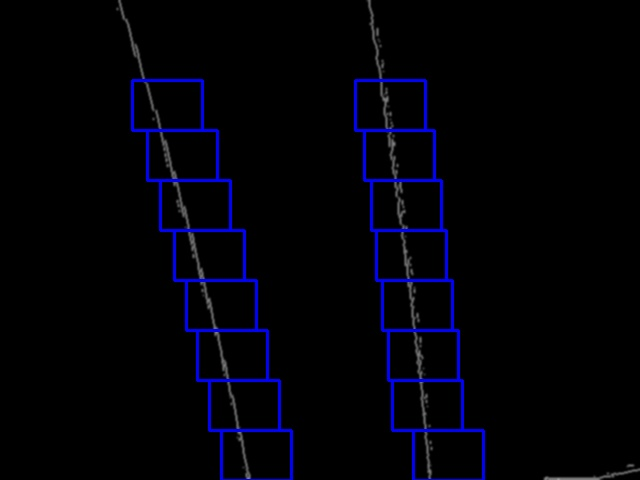

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def draw_rect(img):
    img = img.copy()
    pt1 = (int(WIDTH), int(HEIGHT * h1))
    pt2 = (int(WIDTH * (1 - w1)), int(HEIGHT * h2))  
    pt3 = (int(WIDTH * w1), int(HEIGHT * h2))
    pt4 = (int(0), int(HEIGHT * h1))

    cv2.line(img, pt1, pt2, (0, 255, 0), 2)
    cv2.line(img, pt2, pt3, (0, 255, 0), 2)
    cv2.line(img, pt3, pt4, (0, 255, 0), 2)
    cv2.line(img, pt4, pt1, (0, 255, 0), 2)
    return img

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, initial_left_x, initial_right_x, window_height=50, window_width=70, min_val=50, num_windows=8):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    left_center_x = initial_left_x
    right_center_x = initial_right_x

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            left_center_x = int(np.mean(left_centers)) + left_window_x_start

        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            right_center_x = int(np.mean(right_centers)) + right_window_x_start

    return output_img

# 초기 설정 후, init window만 표시
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 이미지 갱신 루프
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 이미지 크기를 사용하여 초기 위치 설정
    height, width = smoothed_line.shape
    initial_left_x = 8 * width // 20
    initial_right_x = 14 * width // 20

    # 윈도우 생성 및 표시
    init_window = generate_lane_windows(smoothed_line, initial_left_x, initial_right_x)
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()

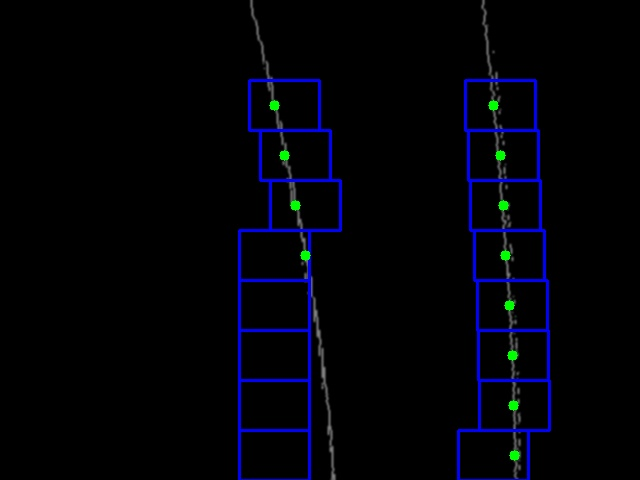

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, left_center_x, right_center_x, window_height=50, window_width=70, min_val=50, num_windows=8):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    new_left_center_x = left_center_x
    new_right_center_x = right_center_x

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        # 좌측 윈도우 설정
        left_window_x_start = max(0, new_left_center_x - window_width // 2)
        left_window_x_end = min(width, new_left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        # 우측 윈도우 설정
        right_window_x_start = max(0, new_right_center_x - window_width // 2)
        right_window_x_end = min(width, new_right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 좌측 윈도우 내 선 검출 및 중앙 위치 갱신
        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            new_left_center_x = int(np.mean(left_centers)) + left_window_x_start
            # 검출된 좌측 선의 중앙에 점 표시
            cv2.circle(output_img, (new_left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

        # 우측 윈도우 내 선 검출 및 중앙 위치 갱신
        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            new_right_center_x = int(np.mean(right_centers)) + right_window_x_start
            # 검출된 우측 선의 중앙에 점 표시
            cv2.circle(output_img, (new_right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

    return output_img, new_left_center_x, new_right_center_x

# 초기 설정
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 초기 위치 설정
height, width = smoothed_line.shape
left_center_x = 8 * width // 20
right_center_x = 14 * width // 20

# 이미지 갱신 루프
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 이전 위치를 기반으로 윈도우 생성 및 라인 추적
    init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, left_center_x, right_center_x)

    # 결과 디스플레이
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()

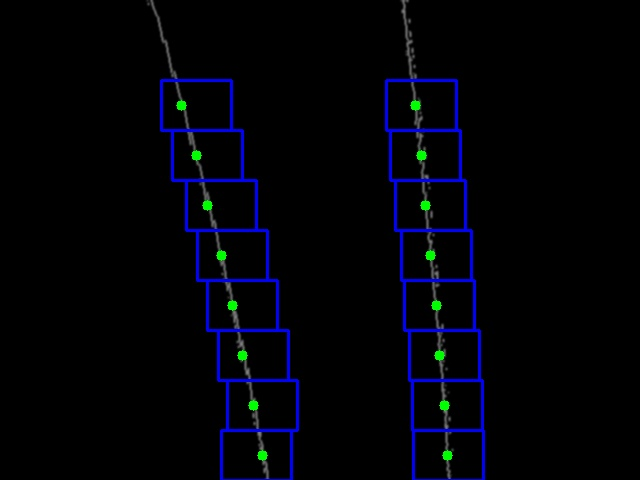

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def draw_rect(img):
    img = img.copy()
    pt1 = (int(WIDTH), int(HEIGHT * h1))
    pt2 = (int(WIDTH * (1 - w1)), int(HEIGHT * h2))  
    pt3 = (int(WIDTH * w1), int(HEIGHT * h2))
    pt4 = (int(0), int(HEIGHT * h1))

    cv2.line(img, pt1, pt2, (0, 255, 0), 2)
    cv2.line(img, pt2, pt3, (0, 255, 0), 2)
    cv2.line(img, pt3, pt4, (0, 255, 0), 2)
    cv2.line(img, pt4, pt1, (0, 255, 0), 2)
    return img

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, initial_left_x, initial_right_x, window_height=50, window_width=70, min_val=50, num_windows=8):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    left_center_x = initial_left_x
    right_center_x = initial_right_x

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 좌측 윈도우 내 선 검출 및 중앙 위치 갱신
        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            left_center_x = int(np.mean(left_centers)) + left_window_x_start
            # 좌측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

        # 우측 윈도우 내 선 검출 및 중앙 위치 갱신
        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            right_center_x = int(np.mean(right_centers)) + right_window_x_start
            # 우측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

    return output_img

# 초기 설정 후, init window만 표시
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 이미지 갱신 루프
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 이미지 크기를 사용하여 초기 위치 설정
    height, width = smoothed_line.shape
    initial_left_x = 8 * width // 20
    initial_right_x = 14 * width // 20

    # 윈도우 생성 및 표시
    init_window = generate_lane_windows(smoothed_line, initial_left_x, initial_right_x)
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()

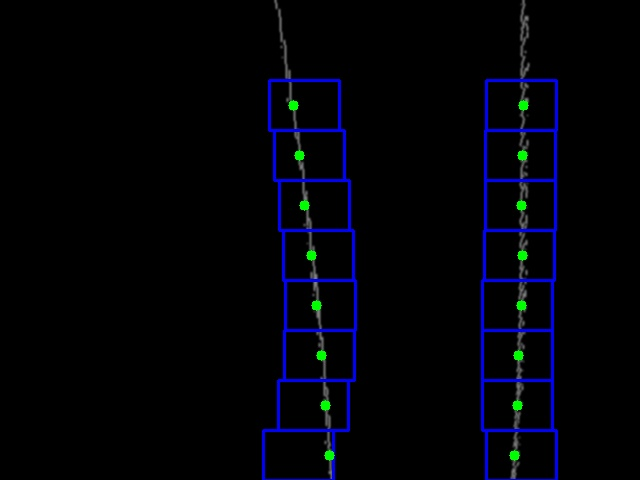

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

# 카메라 설정
cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, left_center_x, right_center_x, window_height=50, window_width=70, min_val=50, num_windows=8, alpha=0.5):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 좌측 윈도우 내 선 검출 및 중앙 위치 갱신
        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            detected_left_center_x = int(np.mean(left_centers)) + left_window_x_start
            # 좌측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (detected_left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)
            # 중앙 위치를 완화하여 갱신
            left_center_x = int(alpha * left_center_x + (1 - alpha) * detected_left_center_x)

        # 우측 윈도우 내 선 검출 및 중앙 위치 갱신
        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            detected_right_center_x = int(np.mean(right_centers)) + right_window_x_start
            # 우측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (detected_right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)
            # 중앙 위치를 완화하여 갱신
            right_center_x = int(alpha * right_center_x + (1 - alpha) * detected_right_center_x)

    return output_img, left_center_x, right_center_x

# 초기 설정 후, 첫 프레임에서만 init 위치 사용
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 이미지 크기를 사용하여 초기 위치 설정
height, width = smoothed_line.shape
initial_left_x = 8 * width // 20
initial_right_x = 14 * width // 20

# 첫 프레임에서 init 위치를 기반으로 윈도우 생성
init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, initial_left_x, initial_right_x)
cam.display_jupyter(init_window)

# 이후 프레임에서는 엣지 기반으로 윈도우를 이동
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 윈도우 생성 및 표시 (이전 위치 기반)
    init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, left_center_x, right_center_x)
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()


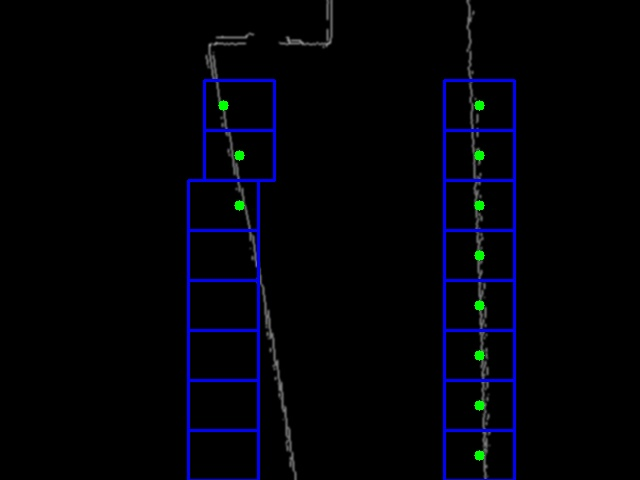

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

# 카메라 설정
cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, left_center_x, right_center_x, window_height=50, window_width=70, min_val=50, num_windows=8, alpha_top=0.5, alpha_bottom=0.2, threshold=10):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 위치 완화 비율 설정
        alpha = alpha_top if i < num_windows // 2 else alpha_bottom

        # 좌측 윈도우 내 선 검출 및 중앙 위치 갱신
        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            detected_left_center_x = int(np.mean(left_centers)) + left_window_x_start
            # 위치 변화가 임계치 이상일 때만 업데이트
            if abs(detected_left_center_x - left_center_x) > threshold:
                left_center_x = int(alpha * left_center_x + (1 - alpha) * detected_left_center_x)
            # 좌측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

        # 우측 윈도우 내 선 검출 및 중앙 위치 갱신
        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            detected_right_center_x = int(np.mean(right_centers)) + right_window_x_start
            # 위치 변화가 임계치 이상일 때만 업데이트
            if abs(detected_right_center_x - right_center_x) > threshold:
                right_center_x = int(alpha * right_center_x + (1 - alpha) * detected_right_center_x)
            # 우측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

    return output_img, left_center_x, right_center_x

# 초기 설정 후, 첫 프레임에서만 init 위치 사용
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 이미지 크기를 사용하여 초기 위치 설정
height, width = smoothed_line.shape
initial_left_x = 8 * width // 20
initial_right_x = 14 * width // 20

# 첫 프레임에서 init 위치를 기반으로 윈도우 생성
init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, initial_left_x, initial_right_x)
cam.display_jupyter(init_window)

# 이후 프레임에서는 엣지 기반으로 윈도우를 이동
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 윈도우 생성 및 표시 (이전 위치 기반)
    init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, left_center_x, right_center_x)
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()


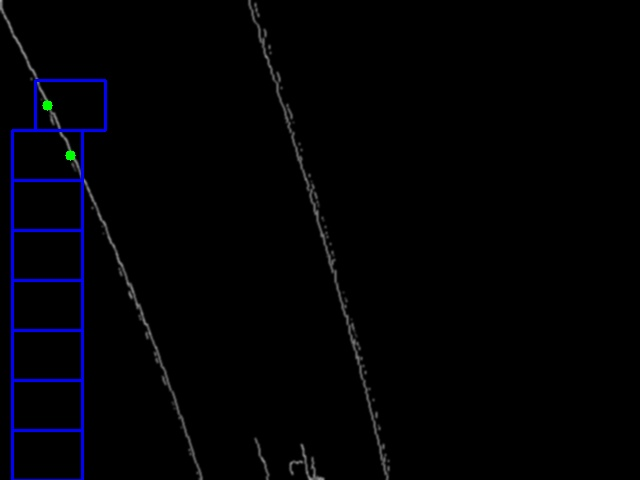

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

# 카메라 설정
cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, left_center_x, right_center_x, window_height=50, window_width=70, min_val=50, num_windows=8):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        # 각 윈도우의 좌/우측 시작점과 끝점을 계산
        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        # 윈도우를 표시
        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 좌측 윈도우 내에서 edge 검출 및 위치 갱신
        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            left_center_x = int(np.mean(left_centers)) + left_window_x_start
            # 검출된 좌측 edge의 중앙에 녹색 점 표시
            cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

        # 우측 윈도우 내에서 edge 검출 및 위치 갱신
        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            right_center_x = int(np.mean(right_centers)) + right_window_x_start
            # 검출된 우측 edge의 중앙에 녹색 점 표시
            cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

    return output_img, left_center_x, right_center_x

# 초기 설정 후, 첫 프레임에서만 init 위치 사용
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 이미지 크기를 사용하여 초기 위치 설정
height, width = smoothed_line.shape
initial_left_x = 8 * width // 20
initial_right_x = 14 * width // 20

# 첫 프레임에서 init 위치를 기반으로 윈도우 생성
init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, initial_left_x, initial_right_x)
cam.display_jupyter(init_window)

# 이후 프레임에서는 엣지 기반으로 윈도우를 이동
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 윈도우 생성 및 표시 (이전 위치 기반)
    init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, left_center_x, right_center_x)
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()

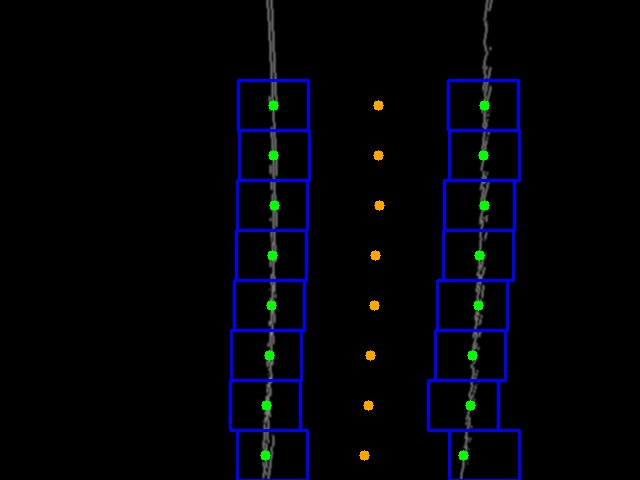

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

# 카메라 설정
cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def generate_lane_windows(img, left_center_x, right_center_x, window_height=50, window_width=70, min_val=50, num_windows=8):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for i in range(num_windows):
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        # 좌측 윈도우 설정
        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

        # 우측 윈도우 설정
        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 좌측 윈도우 내 선 검출 및 중앙 위치 갱신
        left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if left_lines is not None:
            left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
            left_center_x = int(np.mean(left_centers)) + left_window_x_start
            # 좌측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

        # 우측 윈도우 내 선 검출 및 중앙 위치 갱신
        right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
        if right_lines is not None:
            right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
            right_center_x = int(np.mean(right_centers)) + right_window_x_start
            # 우측 선의 중앙에 녹색 점 표시
            cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)

        # 좌측과 우측 윈도우의 중앙 위치 계산하여 주황색 점 표시
        center_x = (left_center_x + right_center_x) // 2
        cv2.circle(output_img, (center_x, (y_start + y_end) // 2), 5, (0, 165, 255), -1)  # 주황색 점 표시

    return output_img, left_center_x, right_center_x

# 초기 설정 후, 첫 프레임에서 init 위치 사용
frame = cam.get_frame()
bird_view = bird_eye_view(frame)
edges = canny_detector(bird_view)
smoothed_line = smooth_lines(edges)

# 이미지 크기를 사용하여 초기 위치 설정
height, width = smoothed_line.shape
initial_left_x = 8 * width // 20
initial_right_x = 14 * width // 20

# 첫 프레임에서 init 위치를 기반으로 윈도우 생성
init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, initial_left_x, initial_right_x)
cam.display_jupyter(init_window)

# 이후 프레임에서는 엣지 기반으로 윈도우를 이동
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 윈도우 생성 및 표시 (이전 위치 기반)
    init_window, left_center_x, right_center_x = generate_lane_windows(smoothed_line, left_center_x, right_center_x)
    cam.display_jupyter(init_window)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()


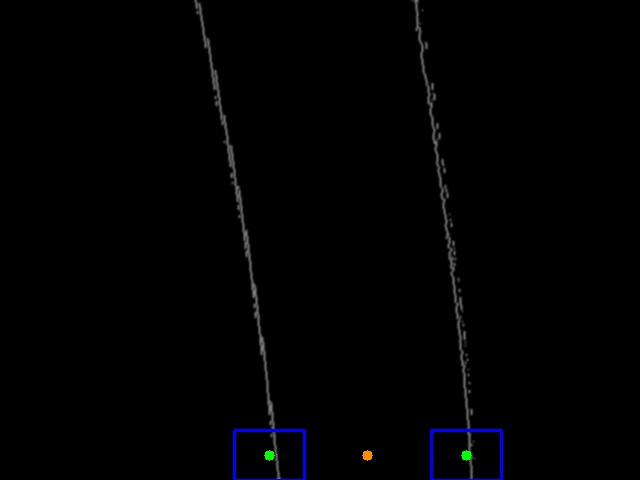

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

# 카메라 설정
cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def find_bottom_edges_and_draw_window(img, window_height=50, window_width=70, min_val=50):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # 하단부 윈도우 위치 설정
    y_start = height - window_height
    y_end = height

    left_center_x, right_center_x = None, None

    # 왼쪽 엣지를 찾기 위해 가장 왼쪽부터 중앙까지 탐색
    # 여기서 왼쪽 엣지를 width의 왼쪽부터 중앙에 가까운 지점까지만 탐색하여 검출
    for x in range(0, width - 70):
        if img[y_start:y_end, x].any():  # 엣지가 검출된 위치
            left_center_x = x
            break

    # 오른쪽 엣지를 찾기 위해 왼쪽 엣지 위치를 기준으로 5픽셀 떨어진 위치에서 탐색 시작
    # 중앙에서 오른쪽 끝 부분까지 탐색하여 오른쪽 엣지 검출
    if left_center_x is not None:
        for x in range(left_center_x + 5 + 70, width):
            if img[y_start:y_end, x].any():  # 엣지가 검출된 위치
                right_center_x = x
                break

    # 왼쪽 엣지와 오른쪽 엣지를 기준으로 하단 윈도우 생성
    if left_center_x is not None:
        left_window_x_start = max(0, left_center_x - window_width // 2)
        left_window_x_end = min(width, left_center_x + window_width // 2)
        cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)
        cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)  # 초록색 점

    if right_center_x is not None:
        right_window_x_start = max(0, right_center_x - window_width // 2)
        right_window_x_end = min(width, right_center_x + window_width // 2)
        cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)
        cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)  # 초록색 점

    # 왼쪽과 오른쪽 엣지의 중앙에 주황색 점 표시
    if left_center_x is not None and right_center_x is not None:
        center_x = (left_center_x + right_center_x) // 2
        center_y = (y_start + y_end) // 2
        cv2.circle(output_img, (center_x, center_y), 5, (0, 140, 255), -1)  # 주황색 점

    return output_img

# 메인 루프
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 엣지를 찾고 하단부에 윈도우를 그리기
    result_img = find_bottom_edges_and_draw_window(smoothed_line)
    cam.display_jupyter(result_img)

    # 'q' 키를 입력하면 루프 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.stop()
cv2.destroyAllWindows()

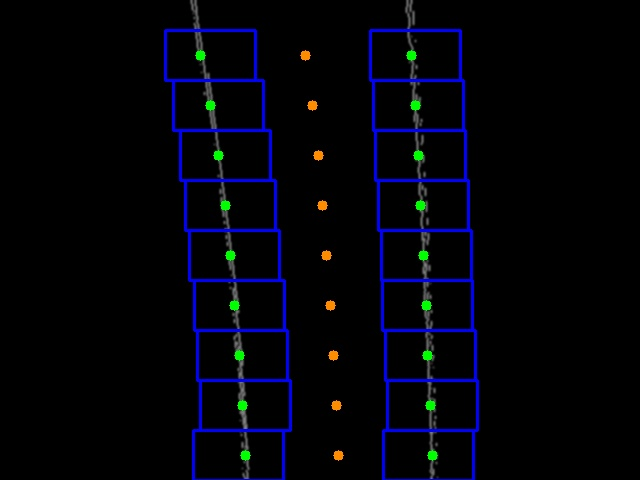

In [ ]:
import cv2
import numpy as np
from pinkylib import Camera

# 카메라 설정
cam = Camera()
cam.start()

WIDTH = 640
HEIGHT = 480

h1 = 0.725
h2 = 0.4
w1 = 0.25

def bird_eye_view(img):
    src_point = np.array(
        [[0, h1 * HEIGHT], [WIDTH, h1 * HEIGHT], [w1 * WIDTH, h2 * HEIGHT], [(1 - w1) * WIDTH, h2 * HEIGHT]],
        dtype=np.float32
    )
    dst_point = np.array([[0, HEIGHT], [WIDTH, HEIGHT], [0, 0], [WIDTH, 0]], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return dst

def canny_detector(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

def smooth_lines(img, kernel_size=5):
    blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return blurred

def find_edges_and_draw_windows(img, window_height=50, window_width=90, min_val=50, num_windows=9):
    height, width = img.shape
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # 첫 번째 윈도우를 하단에서 설정
    y_start = height - window_height
    y_end = height

    # 첫 번째 윈도우에서 엣지를 찾아 좌우 중심을 설정
    left_center_x, right_center_x = None, None

    # 왼쪽 엣지를 찾기 위해 가장 왼쪽부터 중앙까지 탐색
    for x in range(0, width - window_width):
        if img[y_start:y_end, x].any():
            left_center_x = x
            break

    # 오른쪽 엣지를 찾기 위해 중앙부터 끝까지 탐색
    if left_center_x is not None:
        for x in range(left_center_x + 5 + window_width//2, width):
            if img[y_start:y_end, x].any():
                right_center_x = x
                break

    # 슬라이딩 윈도우를 사용하여 윈도우 생성 및 엣지 탐색 반복
    for i in range(num_windows):
        # 윈도우의 y 범위 설정 (위쪽으로 이동)
        y_start = height - (i + 1) * window_height
        y_end = y_start + window_height

        # 좌측 윈도우 내 엣지 찾기 및 초록색 점 표시
        if left_center_x is not None:
            left_window_x_start = max(0, left_center_x - window_width // 2)
            left_window_x_end = min(width, left_center_x + window_width // 2)
            left_window = img[y_start:y_end, left_window_x_start:left_window_x_end]

            # 새로운 엣지 중심을 찾고 좌측 윈도우 갱신
            left_lines = cv2.HoughLinesP(left_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
            if left_lines is not None:
                left_centers = [(x1 + x2) // 2 for x1, _, x2, _ in left_lines[:, 0]]
                left_center_x = int(np.mean(left_centers)) + left_window_x_start
                # 초록색 점 표시
                cv2.circle(output_img, (left_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)
            # 좌측 윈도우 표시
            cv2.rectangle(output_img, (left_window_x_start, y_start), (left_window_x_end, y_end), (255, 0, 0), 2)

        # 우측 윈도우 내 엣지 찾기 및 초록색 점 표시
        if right_center_x is not None:
            right_window_x_start = max(0, right_center_x - window_width // 2)
            right_window_x_end = min(width, right_center_x + window_width // 2)
            right_window = img[y_start:y_end, right_window_x_start:right_window_x_end]

            # 새로운 엣지 중심을 찾고 우측 윈도우 갱신
            right_lines = cv2.HoughLinesP(right_window, 1, np.pi / 180, threshold=min_val, minLineLength=15, maxLineGap=10)
            if right_lines is not None:
                right_centers = [(x1 + x2) // 2 for x1, _, x2, _ in right_lines[:, 0]]
                right_center_x = int(np.mean(right_centers)) + right_window_x_start
                # 초록색 점 표시
                cv2.circle(output_img, (right_center_x, (y_start + y_end) // 2), 5, (0, 255, 0), -1)
            # 우측 윈도우 표시
            cv2.rectangle(output_img, (right_window_x_start, y_start), (right_window_x_end, y_end), (255, 0, 0), 2)

        # 좌측과 우측 초록색 점 사이에 주황색 점 표시
        if left_center_x is not None and right_center_x is not None:
            center_x = (left_center_x + right_center_x) // 2
            center_y = (y_start + y_end) // 2
            cv2.circle(output_img, (center_x, center_y), 5, (0, 140, 255), -1)  # 주황색 점

    return output_img

# 메인 루프
while True:
    frame = cam.get_frame()
    bird_view = bird_eye_view(frame)
    edges = canny_detector(bird_view)
    smoothed_line = smooth_lines(edges)

    # 엣지를 찾고 하단부에서 윈도우 슬라이딩으로 위로 확장
    result_img = find_edges_and_draw_windows(smoothed_line)
    cam.display_jupyter(result_img)

cam.stop()
cv2.destroyAllWindows()
